<a href="https://colab.research.google.com/github/ljham/RNDL-shoes/blob/main/Proyecto_Programaci%C3%B3n_Deep_Learning_Grupo_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Programación: Dataset Shoes vs Sandals vs Boots
### Grupo 3: Guillermo Calderón Hernández, Luis Jama Tello y Guillermo Roberto Agusti
#### Link dataset: htps://bit.ly/3U0QpZj

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.16-py3-none-any.whl size=110683 sha256=896ddfdf75abc95c11d7c5c0fba252a625ef40f16ff4558353eb1b08b4feb45e
  Stored in directory: /root/.cache/pip/wheels/43/4b/fb/736478af5e8004810081a06259f9aa2f7c3329fc5d03c2c412
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.16
    Uninstalling kaggle-1.5.16:
      Successfully uninstalled kaggle-1.5.16


In [3]:
# Seleccionar el API Token personal previamente descargado (fichero kaggle.json)
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"luisjham","key":"7f5f28ed549ad4cd1ec09c72e701332c"}'}

In [4]:
# Creamos un directorio en el que copiamos el fichero kaggle.json
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images --force


 83% 39.0M/47.0M [00:00<00:00, 101MB/s] 
100% 47.0M/47.0M [00:00<00:00, 106MB/s]


In [51]:
# Creemos un directorio para descomprimir los datos
!rm -R dataset/
!mkdir -p dataset

In [52]:
# Descomprimimos los datos y los dejamos listos para trabajar
# /content/shoe-vs-sandal-vs-boot-dataset-15k-images.zip

# /content/dataset/Shoe vs Sandal vs Boot Dataset

!unzip -q shoe-vs-sandal-vs-boot-dataset-15k-images.zip -d '/content/dataset/'
!mv /content/dataset/Shoe\ vs\ Sandal\ vs\ Boot\ Dataset/*  /content/dataset
!rm -R "/content/dataset/Shoe vs Sandal vs Boot Dataset"

In [ ]:
!pwd

/content


In [53]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from sklearn.metrics import classification_report

batch_size = 32
img_size = (160, 160)
seed = 42

In [54]:
# Funciones base
def visualize_learning_curve(H):
  epochs = len(H.history["loss"])
  plt.style.use("ggplot")
  plt.figure()
  plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
  plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
  plt.plot(np.arange(0, epochs), H.history["accuracy"], label="train_acc")
  plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label="val_acc")
  plt.title("Training Loss and Accuracy")
  plt.xlabel("Epoch #")
  plt.ylabel("Loss/Accuracy")
  plt.legend()


def evaluate_model(model, x, y):
  print("[INFO]: Evaluando red neuronal...")
  predictions = model.predict(x, batch_size=batch_size)
  print(classification_report(y, predictions.argmax(axis=1)))

#### Preparación del Dataset

Found 15000 files belonging to 3 classes.
Using 12000 files for training.
Using 3000 files for validation.
data.shape :  (32, 160, 160, 3)
labels.shape :  (32,)
class_names:  ['Boot', 'Sandal', 'Shoe']


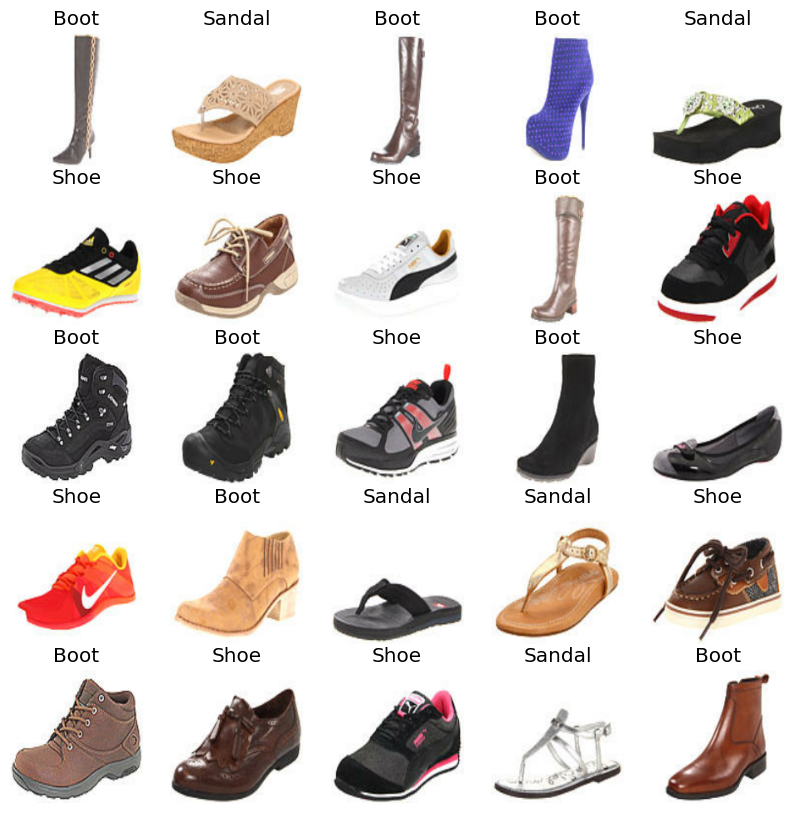

Dataset de Entrenamiento: 12000 muestras
Dataset de Validación: 3008 muestras


In [55]:
# dataset = image_dataset_from_directory("dataset/", label_mode="int", batch_size=batch_size, image_size=(102,136), validation_split=0.2, subset="both", shuffle=True, seed=seed)
# dataset = image_dataset_from_directory("/kaggle/input/shoe-vs-sandal-vs-boot-dataset-15k-images/Shoe vs Sandal vs Boot Dataset", label_mode="int", batch_size=batch_size, image_size=img_size, validation_split=0.2, subset="both", shuffle=True, seed=seed)

dataset = image_dataset_from_directory("dataset/", label_mode="int", batch_size=batch_size, image_size=img_size, validation_split=0.2, subset="both", shuffle=True, seed=seed)

train_dataset = dataset[0]
val_dataset = dataset[1]

train_dataset_card = tf.data.experimental.cardinality(train_dataset).numpy()
val_dataset_card = tf.data.experimental.cardinality(val_dataset).numpy()

# Training Data
for data, labels in train_dataset.take(1):
    print('data.shape : ', data.shape)
    print('labels.shape : ', labels.shape)

class_names = train_dataset.class_names
print('class_names: ',class_names)
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

print(f"Dataset de Entrenamiento: %d muestras" % (train_dataset_card*batch_size))
print(f"Dataset de Validación: %d muestras" % (val_dataset_card*batch_size))

#### Acondicionando el conjunto de datos

In [66]:
import tensorflow_datasets as tfds

# Normaliza las imágenes llevandolas al rango de [0,1]
# Función de Normalización de Imágenes
def process_image_normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

# Obtenemos el array con las imágenes y las etiquetas de test
# Para poder Evaluar los resultados con la librerìa de sklearn
def convert_dataset_to_numpy(test_dataset):
  # Convierte a numpy array cada elemento del tensor
  test_dict_numpy = tfds.as_numpy(test_dataset)

  # Convierte el diccionario de numpy array devuelto en
  # un array único para imagenes y etiquetas
  arr_test_label = []
  arr_test_image = []
  first_image = True
  for elem in test_dict_numpy:
    if first_image:
      arr_test_image = elem[0]
      arr_test_label = elem[1]
      first_image = False
    else:
      arr_test_image = np.vstack([arr_test_image, elem[0]])
      arr_test_label = np.hstack([arr_test_label, elem[1]])
  return arr_test_image, arr_test_label

# Aplica la Normalización en el dataset de Training y de Validación
train_ds_norm = train_dataset.map(process_image_normalize)
val_ds_norm = val_dataset.map(process_image_normalize)

# Calcula el 80% del tamaño del dataset de Training
train_ds_pt_size = int(tf.data.experimental.cardinality(train_ds_norm).numpy()*0.8)
print('train_ds_pt_size : ', train_ds_pt_size)

# Divide el dataset de entrenamiento en 80% entrenamiento y 20% para test
train_ds_pt = train_ds_norm.shuffle(batch_size,seed=seed).take(train_ds_pt_size).shuffle(batch_size)
test_ds_pt  = train_ds_norm.shuffle(batch_size,seed=seed).skip(train_ds_pt_size)

train_ds_pt_card = tf.data.experimental.cardinality(train_ds_pt).numpy()
print(f"Dataset de Entrenamiento: %d muestras" % (train_ds_pt_card*batch_size))
test_ds_pt_card = tf.data.experimental.cardinality(test_ds_pt).numpy()
print(f"Dataset de Pruebas: %d muestras" % (test_ds_pt_card*batch_size))

# Convierte Dataset a Numpy array
arr_test_image, arr_test_label = convert_dataset_to_numpy(test_ds_pt)

print(arr_test_image.shape)
# print(arr_test_image[0])
print(arr_test_label.shape)
# print(arr_test_label[0])

train_ds_pt_size :  300
Dataset de Entrenamiento: 9600 muestras
Dataset de Pruebas: 2400 muestras
(2400, 160, 160, 3)
(2400,)


In [68]:
print(arr_test_image[10, 80:110, 2])

[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]


### Creando la arquitectura de una red Perceptron Multicapa

[INFO]: Entrenando la red neuronal...
Epoch 1/5
300/300 [==============================] - 17s 47ms/step - loss: 0.9053 - accuracy: 0.5993 - val_loss: 0.5232 - val_accuracy: 0.7690
Epoch 2/5
300/300 [==============================] - 13s 40ms/step - loss: 0.5410 - accuracy: 0.7734 - val_loss: 0.6353 - val_accuracy: 0.7470
Epoch 3/5
300/300 [==============================] - 14s 42ms/step - loss: 0.4720 - accuracy: 0.8053 - val_loss: 0.5602 - val_accuracy: 0.7593
Epoch 4/5
300/300 [==============================] - 13s 40ms/step - loss: 0.4203 - accuracy: 0.8316 - val_loss: 0.3688 - val_accuracy: 0.8573
Epoch 5/5
300/300 [==============================] - 13s 39ms/step - loss: 0.3795 - accuracy: 0.8464 - val_loss: 0.4064 - val_accuracy: 0.8373
[INFO]: Evaluando red neuronal...
75/75 [==============================] - 1s 8ms/step
              precision    recall  f1-score   support

           0       0.94      0.82      0.88       810
           1       0.68      0.93      0.78       7

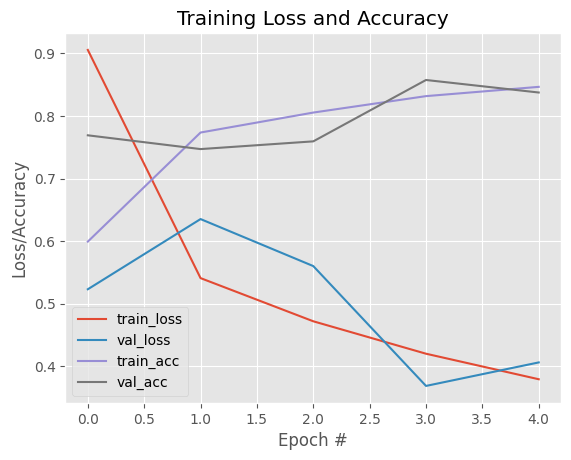

In [69]:
# Imports necesarios
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD

# Arquitectura de red - modo API Sequential

mlp = Sequential()
mlp.add(Flatten())
mlp.add(Dense(2048, input_shape=(160*160*3,), activation="relu"))
mlp.add(Dense(1024, activation="relu"))
mlp.add(Dense(512, activation="relu"))
mlp.add(Dense(128, activation="relu"))
mlp.add(Dense(32, activation="relu"))
mlp.add(Dense(10, activation="softmax"))

# Compilamos el modelo y entrenamos

mlp.compile(optimizer=SGD(learning_rate=0.01),
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"]
            )

# Entrenamos el perceptrón multicapa
print("[INFO]: Entrenando la red neuronal...")
H = mlp.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(mlp, arr_test_image, arr_test_label)

#### Creando la Arquitectura de Red Neuronal Convolucional (CNN)

In [70]:
# Construccion de una red CNN
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Red feedforward API secuencial
convnet = Sequential()

# BASE MODEL
# BM - Bloque Convolución 1
convnet.add(layers.Conv2D(32, (3,3), input_shape=(160,160,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# BM - Bloque Convolución 2
convnet.add(layers.Conv2D(64, (3,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# BM - Bloque Convolución 3
convnet.add(layers.Conv2D(128, (3,3), activation="relu", padding="same"))
convnet.add(layers.MaxPooling2D((2,2)))

# TOP MODEL
convnet.add(layers.Flatten())
convnet.add(layers.Dense(64, activation="relu"))
convnet.add(layers.Dense(3, activation="softmax"))

convnet.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 160, 160, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 80, 80, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 80, 80, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 40, 40, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_14 (Conv2D)          (None, 40, 40, 128)       73856     
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 20, 20, 128)      

In [71]:
# Compilación
convnet.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy")

In [72]:
# Entrenamiento
H = convnet.fit(train_ds_pt, epochs=5, steps_per_epoch=train_ds_pt_card, validation_data=val_ds_norm)

Epoch 1/5
300/300 [==============================] - 14s 36ms/step - loss: 0.3794 - accuracy: 0.8481 - val_loss: 0.2164 - val_accuracy: 0.9240
Epoch 2/5
300/300 [==============================] - 13s 40ms/step - loss: 0.1654 - accuracy: 0.9444 - val_loss: 0.1534 - val_accuracy: 0.9470
Epoch 3/5
300/300 [==============================] - 13s 40ms/step - loss: 0.1239 - accuracy: 0.9576 - val_loss: 0.1173 - val_accuracy: 0.9620
Epoch 4/5
300/300 [==============================] - 11s 33ms/step - loss: 0.0834 - accuracy: 0.9708 - val_loss: 0.1094 - val_accuracy: 0.9627
Epoch 5/5
300/300 [==============================] - 13s 40ms/step - loss: 0.0560 - accuracy: 0.9808 - val_loss: 0.0872 - val_accuracy: 0.9737


[INFO]: Evaluando red neuronal...
75/75 [==============================] - 1s 12ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       810
           1       0.97      0.95      0.96       761
           2       0.97      0.97      0.97       829

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400



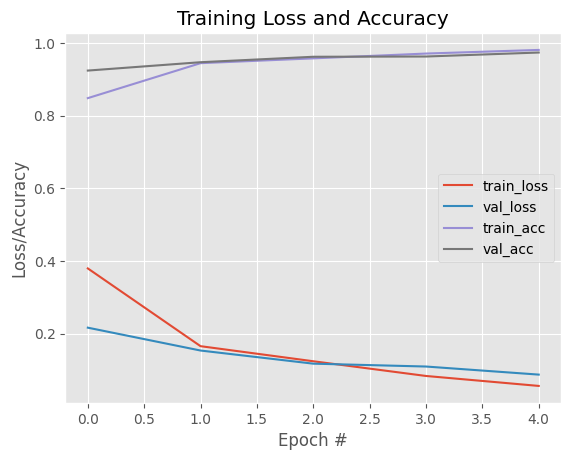

In [73]:
# Evaluación + Testeo
# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, arr_test_image, arr_test_label)

 **Usar aumento de datos**

In [83]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])


**Cambiar la escala de los valores de píxeles**

El modelo tf.keras.applications.MobileNetV2 para usarlo como modelo base requiere valores de píxel en el rango [-1, 1] , pero en este punto, los valores de píxel en las imágenes están en [0, 255] . Para volver a escalarlos se utiliza el método de preprocesamiento incluido con el modelo.

In [96]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)


**Crear el modelo base a partir de las convnets preentrenadas**

In [97]:
IMG_SHAPE = img_size + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')


 Este extractor de características convierte cada imagen de 160x160x3 en un bloque de características de 5x5x1280 . Veamos qué le hace a un lote de imágenes de ejemplo:



In [98]:
image_batch, label_batch = next(iter(train_ds_pt))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


**Extracción de características**

En este paso, congelará la base convolucional creada en el paso anterior y la utilizará como extractor de características. Además, agrega un clasificador encima y entrena el clasificador de nivel superior.

**Congelar la base convolucional**

Es importante congelar la base convolucional antes de compilar y entrenar el modelo. Congelar (estableciendo layer.trainable = False) evita que los pesos en una capa determinada se actualicen durante el entrenamiento. MobileNet V2 tiene muchas capas, por lo que establecer la bandera trainable de todo el modelo en False las congelará todas.

In [101]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_8[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

**Agregar un encabezado de clasificación**

Para generar predicciones a partir del bloque de entidades, promedie las ubicaciones espaciales de 5x5 utilizando una capa tf.keras.layers.GlobalAveragePooling2D para convertir las entidades en un único vector de 1280 elementos por imagen.

In [110]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)


(32, 1280)


Aplique una capa tf.keras.layers.Dense para convertir estas características en una sola predicción por imagen. No necesita una función de activación aquí porque esta predicción se tratará como un logit o un valor de predicción sin procesar. Los números positivos predicen la clase 1, los números negativos predicen la clase 0.

In [111]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)


(32, 1)


Cree un modelo encadenando las capas de aumento de datos, reescalado, base_model y extractor de características mediante la API funcional de Keras . Como se mencionó anteriormente, use training=False ya que nuestro modelo contiene una capa BatchNormalization .

In [112]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)
model.summary()


Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 160, 160, 3)]     0         
                                                                 
 sequential_8 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

**Compilar el modelo**

In [105]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
len(model.trainable_variables)

2

**Entrenar al modelo**

In [106]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds_norm)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))


94/94 [==============================] - 4s 28ms/step - loss: 0.6870 - accuracy: 0.3213
initial loss: 0.69
initial accuracy: 0.32


In [107]:
H = model.fit(train_dataset,
              epochs=initial_epochs,
              validation_data=val_ds_norm)


Epoch 1/10
375/375 [==============================] - 20s 45ms/step - loss: -0.0772 - accuracy: 0.3483 - val_loss: 0.0432 - val_accuracy: 0.3330
Epoch 2/10
375/375 [==============================] - 17s 46ms/step - loss: -1.2932 - accuracy: 0.3954 - val_loss: -0.0077 - val_accuracy: 0.3330
Epoch 3/10
375/375 [==============================] - 15s 40ms/step - loss: -2.3398 - accuracy: 0.4144 - val_loss: -0.0673 - val_accuracy: 0.3330
Epoch 4/10
375/375 [==============================] - 15s 40ms/step - loss: -3.4325 - accuracy: 0.4136 - val_loss: -0.1057 - val_accuracy: 0.3330
Epoch 5/10
375/375 [==============================] - 15s 40ms/step - loss: -4.5388 - accuracy: 0.4122 - val_loss: -0.1369 - val_accuracy: 0.3330
Epoch 6/10
375/375 [==============================] - 17s 44ms/step - loss: -5.6870 - accuracy: 0.4115 - val_loss: -0.1649 - val_accuracy: 0.3330
Epoch 7/10
375/375 [==============================] - 14s 38ms/step - loss: -6.8284 - accuracy: 0.4122 - val_loss: -0.1941 - 

[INFO]: Evaluando red neuronal...
75/75 [==============================] - 1s 10ms/step
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       810
           1       0.97      0.95      0.96       761
           2       0.97      0.97      0.97       829

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400



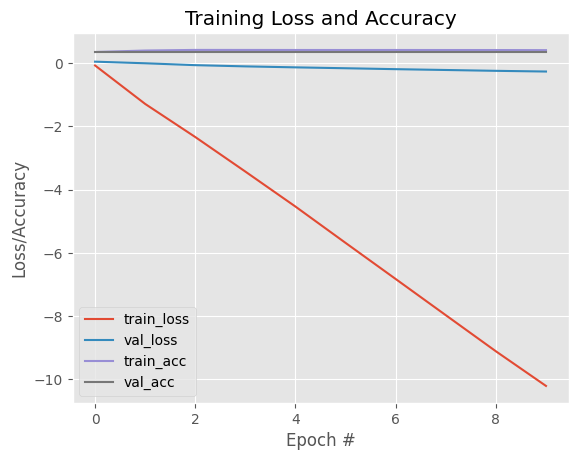

In [108]:
# Evaluación + Testeo
# Learning curves
visualize_learning_curve(H)

# Evaluando el modelo de predicción con las imágenes de test
evaluate_model(convnet, arr_test_image, arr_test_label)

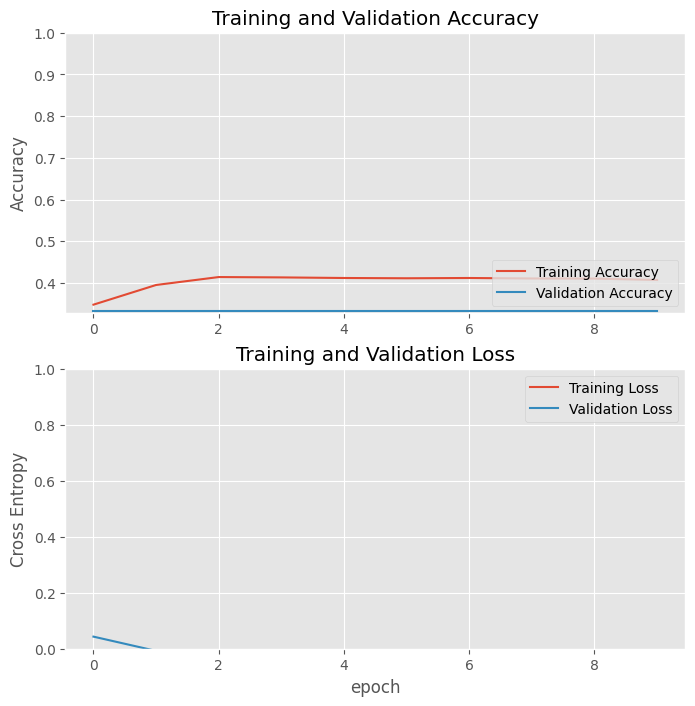

In [109]:
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']

loss = H.history['loss']
val_loss = H.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()